##### Copyright 2020 The TensorFlow Authors.

## Setup

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf


NUM_CLASSES = 3 #Bump/Road
IMG_SIZE =40 #SqueezeNet 90x90
SHOULD_TEST = False

EPOCHS = 40
BATCH_SIZE = 64

In [3]:
# import pandas
# import shutil 
# import os
# csv_file = pandas.read_csv("D:/GP/New version/MIIA PotHole/train_ids_labels.csv") # you can implement options as you want here)
# sorted_csv = csv_file.sort_values(by=['Label'])
# class_names = list(sorted_csv['Label'].unique())
# print(class_names)
# print()
# if not os.path.exists('D:/GP/New version/PotHole/001') or not os.path.exists('D:/GP/New version/PotHole/002'):
#   os.makedirs(os.path.join('D:/GP/New version/PotHole/001'))
#   os.makedirs(os.path.join('D:/GP/New version/PotHole/002'))
#   print("created")

# for i in class_names:
#   temp='00'+str(i+1)          
#   for c in list(sorted_csv[sorted_csv['Label']== i]['Image_ID']):    # c  ->  individual image 
#   # Creating path to the image
#     get_image = os.path.join('D:/GP/New version/MIIA PotHole/all_data/all_data/',c+'.JPG')
#     # print(get_image)
#   # get_image to that path
#     if os.path.exists('D:/GP/New version/PotHole/'+temp):
#         # move the image to this path
#         print(get_image,"Loaded to",temp)
#         move_image = shutil.copy(get_image,'D:/GP/New version/PotHole/'+temp)


In [4]:
# # print(sorted_csv)
# road_images_count=len(sorted_csv[sorted_csv['Label']== 0])
# pothole_images_count=len(sorted_csv[sorted_csv['Label']== 1])
# print("road_images_count: "+str(road_images_count),"\npothole_images_count: "+str(pothole_images_count))


In [5]:
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Note: all images are licensed CC-BY, creators are listed in the LICENSE.txt file.

In [6]:
import pathlib

data_dirs_string=['D:/GP/New version/NEWEST_DATASET_BUMPS','D:/GP/New version/train','D:/GP/New version/PotHole']
data_dirs=[]
for i in data_dirs_string:
  data_dirs.append(pathlib.Path(i))

# data_dir = 'D:/GP/New version/NEWEST_DATASET_BUMPS'
# data_dir = pathlib.Path(data_dir)

# data_dir2 = 'D:/GP/New version/train'
# data_dir2 = pathlib.Path(data_dir2)

# # data_dir3 = 'D:/GP/New version/train'
# # data_dir3 = pathlib.Path(data_dir2)

# data_dir3 = 'D:/GP/New version/PotHole'
# data_dir3 = pathlib.Path(data_dir3)
# image_count_train = len(list(data_dirs[0].glob('*/*.*')))+len(list(data_dirs[1].glob('*/*.*')))+len(list(data_dirs[2].glob('*/*.*'))) 
# print(image_count_train)


In [7]:
class_names=[]
for i in range(NUM_CLASSES):
  Class = np.array(sorted([item.name for item in data_dirs[i].glob('*') if item.name != "LICENSE.txt"]))
  for i in Class:
    if i not in class_names:
      class_names.append(i)
print(class_names)
# class_names = np.array(sorted([item.name for item in data_dir2.glob('*') if item.name != "LICENSE.txt"]))
# print(class_names)
# class_names = np.array(sorted([item.name for item in data_dir3.glob('*') if item.name != "LICENSE.txt"]))
# print(class_names)

['001', '002', '003']


In [8]:

dataSets=[tf.data.Dataset for x in range(NUM_CLASSES)]
dir=[]
image_count_train=np.zeros(NUM_CLASSES)

for j in range(NUM_CLASSES):
  for i in range(NUM_CLASSES):
  # if not os.path.exists(str(data_dirs[i]/+class_names[j]+'/*')): 
    temp=str(class_names[j]+'/*')
    dir.append(str(data_dirs[i]/temp))
  # print(dir)  
  dataSets[j]=(tf.data.Dataset.list_files(dir, shuffle=False))
  dir=[]
  image_count_train[j]=int(len(dataSets[j]))
  dataSets[j] = dataSets[j].shuffle(image_count_train[j], reshuffle_each_iteration=False)
  
print("Length of each dataset: ",image_count_train)
minLen= int(min(image_count_train))
minIndex=np.argmin(image_count_train)
print("Min. Length is: ",minLen)    

list_ds_train=dataSets[minIndex]
for i in range(NUM_CLASSES):
  if i != minIndex:
    # print("hi")
    list_ds_train = list_ds_train.concatenate(dataSets[i].take(minLen))
list_ds_train = list_ds_train.shuffle(NUM_CLASSES*minLen, reshuffle_each_iteration=False)

print('train size:' , len(list(list_ds_train.as_numpy_iterator())))
# list_ds_train = list_ds_train.batch(BATCH_SIZE).prefetch(2)

# list_ds_test = tf.data.Dataset.list_files([str(data_dir2/'*/*')], shuffle=False)
# list_ds_test = list_ds_test.shuffle(image_count_test, reshuffle_each_iteration=False)

Length of each dataset:  [8112. 4267. 1661.]
Min. Length is:  1661
train size: 4983


In [9]:
for f in list_ds_train.take(5):
  print(f.numpy())

# for f in list_ds_test.take(5):
#   print(f.numpy())  

b'D:\\GP\\New version\\train\\002\\bump (769).jpg'
b'D:\\GP\\New version\\PotHole\\003\\zJoDmvMgMfYuuID.JPG'
b'D:\\GP\\New version\\NEWEST_DATASET_BUMPS\\002\\VIDEO0012_006.jpg'
b'D:\\GP\\New version\\NEWEST_DATASET_BUMPS\\002\\MVI_1580 10.jpg'
b'D:\\GP\\New version\\NEWEST_DATASET_BUMPS\\002\\20191011_070047 268.jpg'


The tree structure of the files can be used to compile a `class_names` list.

Split the dataset into training and validation sets:

In [10]:
# image_count=sum(image_count_train)
# print(image_count*0.2)
test_size = int(minLen *0.2)
val_size = int(minLen * 0.2)
test_ds = list_ds_train.take(test_size)
val_ds = list_ds_train.skip(test_size).take(val_size)
train_ds = list_ds_train.skip(val_size+test_size)


You can print the length of each dataset as follows:

In [11]:
print('test size:' , len(list(test_ds.as_numpy_iterator())))
print('train size:' , len(list(train_ds.as_numpy_iterator())))
print('dev size:' , len(list(val_ds.as_numpy_iterator())))

test size: 332
train size: 4319
dev size: 332


Write a short function that converts a file path to an `(img, label)` pair:

In [12]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [13]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

In [14]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

In [16]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [17]:
c=0
c1=0
c2=0
for image, label in train_ds:
  # print("Image shape: ", image.numpy().shape)
  # print("Label: ", label.numpy())
  if(label.numpy()==0):
    c=c+1
  elif (label.numpy()==1):
    c1=c1+1
  elif(label.numpy()==2):
    c2=c2+1
  # print(label.numpy())

for image, label in test_ds:
  # print("Image shape: ", image.numpy().shape)
  # print("Label: ", label.numpy())

  if(label.numpy()==0):
    c=c+1
  elif (label.numpy()==1):
    c1=c1+1
  elif(label.numpy()==2):
    c2=c2+1
  # print(label.numpy())

for image, label in val_ds:
  # print("Image shape: ", image.numpy().shape)
  # print("Label: ", label.numpy())

  if(label.numpy()==0):
    c=c+1
  elif (label.numpy()==1):
    c1=c1+1
  elif(label.numpy()==2):
    c2=c2+1
  # print(label.numpy())
print(c,c1,c2)


  # images.append(image)
  # labels.append(label.numpy())

1661 1661 1661


### Configure dataset for performance

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be added using the `tf.data` API. For more details, visit the [Input Pipeline Performance](../../guide/performance/datasets.ipynb) guide.

In [18]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

### Visualize the data

You can visualize this dataset similarly to the one you created previously:

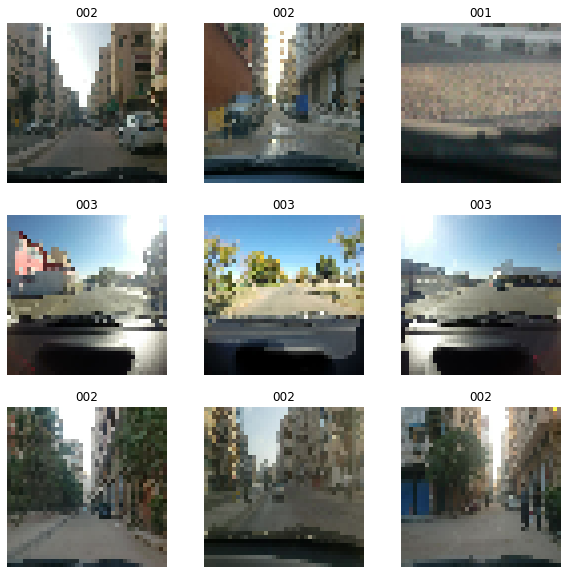

In [19]:
import matplotlib.pyplot as plt

image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### Train a model

For completeness, you will show how to train a simple model using the datasets you have just prepared.

The [Sequential](https://www.tensorflow.org/guide/tf/sequential_model) model consists of three convolution blocks (`tf.tf.layers.Conv2D`) with a max pooling layer (`tf.tf.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.tf.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit the [Image classification](../images/classification.ipynb) tutorial.

In [51]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, BatchNormalization, Concatenate, Dropout, Activation, Input, ZeroPadding2D, LayerNormalization
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.metrics import Accuracy, Recall, Precision

def recall(y_true, y_pred):
    y_true = keras.backend.ones_like(y_true) 
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    all_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true, 0, 1)))
        
    recall = true_positives / (all_positives + keras.backend.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = keras.backend.ones_like(y_true) 
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + keras.backend.epsilon())
    return precision

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+keras.backend.epsilon()))


class FireModule(keras.layers.Layer):
    def __init__(self, s1x1, e1x1, e3x3):
        super(FireModule, self).__init__()
        self.s1x1 = Conv2D(s1x1, kernel_size=(1, 1), padding='same', kernel_initializer='glorot_normal', activation='relu')
        self.e1x1 = Conv2D(e1x1, kernel_size=(1, 1), padding='same', kernel_initializer='glorot_normal', activation='relu')
        self.e3x3 = Conv2D(e3x3, kernel_size=(3, 3), padding='same', kernel_initializer='glorot_normal', activation='relu')
        self.concat = Concatenate(axis=3)
    def get_config(self):
        base_config = super(FireModule, self).get_config()
        #base_config['output_dim'] = self.output_dim
        return base_config

    def call(self, inputs):
        s1x1 = self.s1x1(inputs)
        e1x1 = self.e1x1(s1x1)
        e3x3 = self.e3x3(s1x1)
        concat = self.concat([e1x1, e3x3])
        return concat

# def FireModule(s1, e1, e3, input):
#     squeeze = Conv2D(s1, kernel_size=(1, 1), padding='same', kernel_initializer='glorot_normal', activation='relu')(input)
#     expand1 = Conv2D(e1, kernel_size=(1, 1), padding='same', kernel_initializer='glorot_normal', activation='relu')(squeeze)
#     expand3 = Conv2D(e3, kernel_size=(3, 3), padding='same', kernel_initializer='glorot_normal', activation='relu')(squeeze)
#     concat = Concatenate(axis=1)([expand1, expand3])
#     return concat

def SqueezeNetV1_0(input_shape, nb_classes):
    
    
    input = Input(input_shape)
    padded = ZeroPadding2D((2, 2))(input)
    conv1 = Conv2D(96, kernel_size=(7, 7), strides=(2,2),padding='valid', kernel_initializer='glorot_normal', activation='relu')(padded)
    maxpool1 = MaxPooling2D(pool_size=(3, 3), strides=2)(conv1)
    fire2 = FireModule(16, 64, 64)(maxpool1)
    fire3 = FireModule(16, 64, 64)(fire2)
    fire4 = FireModule(32, 128, 128)(fire3)
    maxpool4 = MaxPooling2D(pool_size=(3, 3), strides=2)(fire4)
    fire5 = FireModule(32, 128, 128)(maxpool4)
    fire6 = FireModule(48, 192, 192)(fire5)
    fire7 = FireModule(48, 192, 192)(fire6)
    fire8 = FireModule(64, 256, 256)(fire7)
    maxpool8 = MaxPooling2D(pool_size=(3, 3), strides=2)(fire8)
    fire9 = FireModule(64, 256, 256)(maxpool8)
    conv10 = Conv2D(1000, kernel_size=(1, 1), strides=1, padding='same', kernel_initializer='glorot_normal', activation='relu')(fire9)
    avgpool10 = AveragePooling2D(conv10.get_shape()[1:3], strides=1)(conv10)
    #reshaped = tf.squeeze(avgpool10, [1, 2])
    flat = Flatten()(avgpool10)
    # output = Activation('softmax')(flat)
    output = Dense(nb_classes, activation='softmax', kernel_initializer='he_normal')(flat)


    model = Model(input, output, name='SqueezeNetV1_0x' + str(IMG_SIZE))
    model.compile(optimizer=Adam(learning_rate=0.001),
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

def SqueezeNetV1_1(input_shape, nb_classes):
    input = Input(input_shape)
    conv1 = Conv2D(64, kernel_size=(3, 3), strides=(2,2),padding='valid')(input)
    maxpool1 = MaxPooling2D(pool_size=(3, 3), strides=2)(conv1)
    fire2 = FireModule(16, 64, 64)(maxpool1)
    fire3 = FireModule(16, 64, 64)(fire2)
    maxpool3 = MaxPooling2D(pool_size=(3, 3), strides=2)(fire3)
    fire4 = FireModule(32, 128, 128)(maxpool3)
    fire5 = FireModule(32, 128, 128)(fire4)
    maxpool5 = MaxPooling2D(pool_size=(3, 3), strides=2)(fire5)
    fire6 = FireModule(48, 192, 192)(maxpool5)
    fire7 = FireModule(48, 192, 192)(fire6)
    fire8 = FireModule(64, 256, 256)(fire7)
    fire9 = FireModule(64, 256, 256)(fire8)
    dropout9 = Dropout(0.8)(fire9)
    conv10 = Conv2D(nb_classes, kernel_size=(1, 1), strides=1, padding='same', activation=None)(dropout9)
    avgpool10 = AveragePooling2D(conv10.get_shape()[1:3])(conv10)
    #reshaped10 = Flatten()(avgpool10)
    output = Flatten()(avgpool10)
    #output = Activation('softmax')(reshaped10)
    #output = Dense(nb_classes, activation='softmax', kernel_initializer='he_normal')(reshaped10)

    model = Model(input, output, name='SqueezeNetV1_1x' + str(IMG_SIZE))
    model.compile(optimizer='adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy', precision, recall, f1_score])
    return model


def FLSCNN(input_shape, nb_classes):
    input = Input(input_shape)

    conv1 = Conv2D(8, kernel_size=(5, 5),activation='relu')(input)
    bn1 = LayerNormalization()(conv1)
    
    maxpool1 = MaxPooling2D(pool_size=(4, 4), strides=2, padding='same')(bn1)
    
    conv2 = Conv2D(16, kernel_size=(5, 5), activation='relu')(maxpool1)
    bn2 = LayerNormalization()(conv2)

    maxpool2 = MaxPooling2D(pool_size=(4, 4), strides=2, padding='same')(bn2)
    
    conv3 = Conv2D(16, kernel_size=(5, 5), activation='relu')(maxpool2)
    bn3 = LayerNormalization()(conv3)

    maxpool3 = MaxPooling2D(pool_size=(3, 3), strides=2)(bn3)

    conv4 = Conv2D(32, kernel_size=(5, 5), activation='relu')(maxpool3)
    bn4 = LayerNormalization()(conv4)

    maxpool4 = MaxPooling2D(pool_size=(5, 5), strides=2, padding='same')(bn4)

    conv5 = Conv2D(32, kernel_size=(1, 1), activation='relu', padding='same')(maxpool4)
    bn5 = LayerNormalization()(conv5)

    maxpool5 = MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid')(bn5)

    #maxpool6 = MaxPooling2D(pool_size=(3, 3), strides=1, padding='valid')(maxpool5)

    fc1 = Dense(32, activation='tanh',)(maxpool5)
    fc2 = Dense(4, activation='tanh',)(fc1)
    fc3 = Dense(nb_classes, activation='softmax',)(fc2)

    output = Flatten()(fc3)

    model = Model(input, output, name='FLSCNNx' + str(IMG_SIZE))
    model.compile(optimizer=Adam(learning_rate=0.09),
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [52]:
for images, labels in train_ds.take(1):
    pass


In [53]:
model = SqueezeNetV1_1(images[0].numpy().shape, NUM_CLASSES)
model.summary()

Model: "SqueezeNetV1_1x40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 40, 40, 3)]       0         
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 19, 19, 64)        1792      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
fire_module_40 (FireModule)  (None, 9, 9, 128)         11408     
_________________________________________________________________
fire_module_41 (FireModule)  (None, 9, 9, 128)         12432     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
fire_module_42 (FireModule)  (None, 4, 4, 256)   

Note: You will only train for a few epochs so this tutorial runs quickly. 

In [54]:
import datetime
# Place the logs in a timestamped subdirectory
# This allows to easy select different training runs
# In order not to overwrite some data, it is useful to have a name with a timestamp
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Specify the callback object
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = (50,80))

# tf.keras.callback.TensorBoard ensures that logs are created and stored
# We need to pass callback object to the fit method
# The way to do this is by passing the list of callback objects, which is in our case just one

In [55]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [56]:
from shutil import rmtree

rmtree('./logs')
model.fit(
  train_ds,
  epochs=EPOCHS,
  validation_data=val_ds,
  callbacks=[tensorboard_callback, cp_callback]
)
model.save('models/'+model.name)


Epoch 1/40
TPPPPPPP:  Tensor("Cast_8:0", shape=(), dtype=int32) PPPPPPP:  Tensor("Sum_7:0", shape=(), dtype=float32)
TPPPPPPP:  Tensor("Cast_11:0", shape=(), dtype=int32) PPPPPPP:  Tensor("Sum_12:0", shape=(), dtype=float32)
TPPPPPPP:  Tensor("Cast_8:0", shape=(), dtype=int32) PPPPPPP:  Tensor("Sum_7:0", shape=(), dtype=float32)
TPPPPPPP:  Tensor("Cast_11:0", shape=(), dtype=int32) PPPPPPP:  Tensor("Sum_12:0", shape=(), dtype=float32)
68/68 [==============================] - ETA: 0s - loss: 0.8743 - accuracy: 0.5483 - precision: 0.9265 - recall: 0.8028 - f1_score: 0.7687TPPPPPPP:  Tensor("Cast_8:0", shape=(), dtype=int32) PPPPPPP:  Tensor("Sum_7:0", shape=(), dtype=float32)
TPPPPPPP:  Tensor("Cast_11:0", shape=(), dtype=int32) PPPPPPP:  Tensor("Sum_12:0", shape=(), dtype=float32)
68/68 [==============================] - 5s 31ms/step - loss: 0.8743 - accuracy: 0.5483 - precision: 0.9265 - recall: 0.8028 - f1_score: 0.7687 - val_loss: 0.6756 - val_accuracy: 0.6416 - val_precision: 1.0000

INFO:tensorflow:Assets written to: models/SqueezeNetV1_1x40\assets


INFO:tensorflow:Assets written to: models/SqueezeNetV1_1x40\assets


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('models/'+model.name, custom_objects={'recall': recall, 'precision': precision,'f1_score':f1_score})


In [ ]:
test_accuracy = tf.keras.metrics.Accuracy()
#ds_test_batch = test_ds.batch(10)

loss, accuracy, prec, rec, f1 = model.evaluate(test_ds)
print("Loss :", loss)
print("Accuracy :", accuracy)
print("Precision :", prec)
print("Recall :", rec)
print("F1-Score :", f1)

#print("Test set accuracy: {:.3%}".format(test_accuracy.result()))


6/6 [==============================] - 1s 20ms/step - loss: 0.4496 - accuracy: 0.8675 - precision: 1.0000 - recall: 1.7040 - f1_score: 1.2600
Loss : 0.44955649971961975
Accuracy : 0.8674699068069458
Precision : 1.0
Recall : 1.7039929628372192
F1-Score : 1.2600265741348267


In [ ]:
model.layers[3].get_weights()

[array([[[[ 0.01556807,  0.07391512,  0.3368279 , ..., -0.07126247,
           -0.2170175 , -0.02033901],
          [-0.02662421, -0.04000798, -0.1027464 , ...,  0.03115628,
            0.05362149, -0.18842499],
          [-0.01606936,  0.23082016, -0.11508348, ...,  0.1606015 ,
           -0.04517771, -0.3237775 ],
          ...,
          [ 0.02123212,  0.07320458,  0.3615402 , ...,  0.2763626 ,
            0.01053592,  0.05924619],
          [-0.18955462,  0.09731818,  0.06794779, ..., -0.08076224,
            0.23056947,  0.00119642],
          [ 0.00852288, -0.07053231, -0.09599829, ..., -0.06583361,
            0.24803385, -0.23970789]]]], dtype=float32),
 array([ 0.04873258, -0.13601622, -0.03618615, -0.02710439,  0.03912748,
        -0.01741141, -0.01453101,  0.03600643, -0.02032084, -0.00836696,
         0.06668332,  0.02978985, -0.01742508, -0.00314302,  0.04586649,
         0.04395663], dtype=float32),
 array([[[[-0.04046103, -0.04101899,  0.03857753, ..., -0.01975333,
     

In [ ]:
weights = model.layers[1].get_weights()

In [ ]:
weights.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
weights[:,:,2,60]

array([[ 0.00660257,  0.05393029,  0.07871939],
       [-0.02834111,  0.02452181, -0.05535853],
       [-0.11845279, -0.07768951, -0.08921076]], dtype=float32)